In [1]:
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

Using TensorFlow backend.


In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [3]:
from sklearn.externals import joblib

In [4]:
import nltk
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Load data from file

In [6]:
merged_data = pd.read_pickle('merged_data_pct_change.pkl')

In [7]:
filtered_merged_data = merged_data[merged_data['1day pct change'].abs() > 3.]

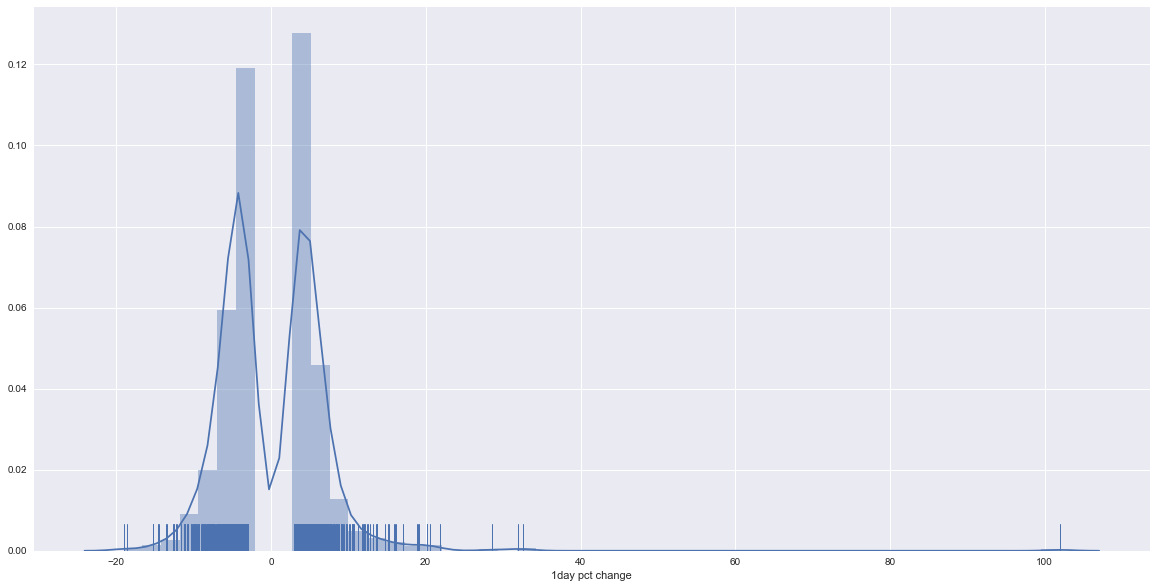

In [8]:
plt.figure(figsize=(20,10))
sns.distplot(filtered_merged_data['1day pct change'], bins=50, rug=True)

In [9]:
len(filtered_merged_data)

1093

# Create train data and test data

In [10]:
X = filtered_merged_data['rawText']
y = filtered_merged_data['1day pct change']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Tf-Idf

### Load from file

In [12]:
#tfidf = joblib.load('tfidf_lemmatokenizer__maxdf0_4__mindf300.pkl')

In [13]:
#tfidf_vectors = tfidf.transform(X_train)

### Recreate vectorizer from scratch

In [14]:
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t.lower(), 'v') for t in word_tokenize(doc)]

In [15]:
tfidf = TfidfVectorizer(max_df=0.5, min_df=20, ngram_range=(1,2),tokenizer=LemmaTokenizer(), stop_words='english')
svd = TruncatedSVD(500)
lsa = make_pipeline(tfidf, svd)

# Run SVD on the training data, then project the training data.
lsa_vectors = lsa.fit_transform(X_train)

In [16]:
lsa_vectors.shape

(874, 500)

In [17]:
#joblib.dump(tfidf, 'tfidf_lemmatokenizer__maxdf0_4__mindf300.pkl')

# DNN model

In [18]:
# define base model
def baseline_model():
    model = Sequential()
    model.add(Dense(100, input_dim=lsa_vectors.shape[1], kernel_initializer='normal', activation='relu'))
    model.add(Dense(20, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [19]:
estimator = KerasRegressor(build_fn=baseline_model, epochs=100, batch_size=5, verbose=2)

In [20]:
'''
kfold = KFold(n_splits=10)
results = cross_val_score(estimator, dense_tfidf_vectors, y_train, cv=kfold)
print("Results: %.2f (%.2f) MSE" % (results.mean(), results.std()))
'''

'\nkfold = KFold(n_splits=10)\nresults = cross_val_score(estimator, dense_tfidf_vectors, y_train, cv=kfold)\nprint("Results: %.2f (%.2f) MSE" % (results.mean(), results.std()))\n'

In [21]:
estimator.fit(lsa_vectors, y_train)

Epoch 1/100
2s - loss: 49.5619
Epoch 2/100
0s - loss: 49.2259
Epoch 3/100
0s - loss: 44.2516
Epoch 4/100
0s - loss: 34.0980
Epoch 5/100
0s - loss: 27.5798
Epoch 6/100
0s - loss: 23.2818
Epoch 7/100
0s - loss: 19.6224
Epoch 8/100
0s - loss: 16.4602
Epoch 9/100
0s - loss: 13.7991
Epoch 10/100
0s - loss: 11.1049
Epoch 11/100
0s - loss: 9.2066
Epoch 12/100
0s - loss: 7.3243
Epoch 13/100
0s - loss: 5.5898
Epoch 14/100
0s - loss: 4.5686
Epoch 15/100
0s - loss: 3.3817
Epoch 16/100
0s - loss: 2.6632
Epoch 17/100
0s - loss: 2.1726
Epoch 18/100
0s - loss: 1.7162
Epoch 19/100
0s - loss: 1.4658
Epoch 20/100
0s - loss: 1.1525
Epoch 21/100
0s - loss: 1.3407
Epoch 22/100
0s - loss: 1.2439
Epoch 23/100
0s - loss: 1.0292
Epoch 24/100
0s - loss: 1.0930
Epoch 25/100
0s - loss: 1.1357
Epoch 26/100
0s - loss: 1.0236
Epoch 27/100
0s - loss: 1.0369
Epoch 28/100
0s - loss: 1.0554
Epoch 29/100
0s - loss: 1.0006
Epoch 30/100
0s - loss: 0.9370
Epoch 31/100
0s - loss: 0.7822
Epoch 32/100
0s - loss: 0.8153
Epoch 3

In [22]:
test_vectors = lsa.transform(X_test)

In [23]:
test_vectors.shape

(219, 500)

In [24]:
y_predicted = estimator.predict(test_vectors)

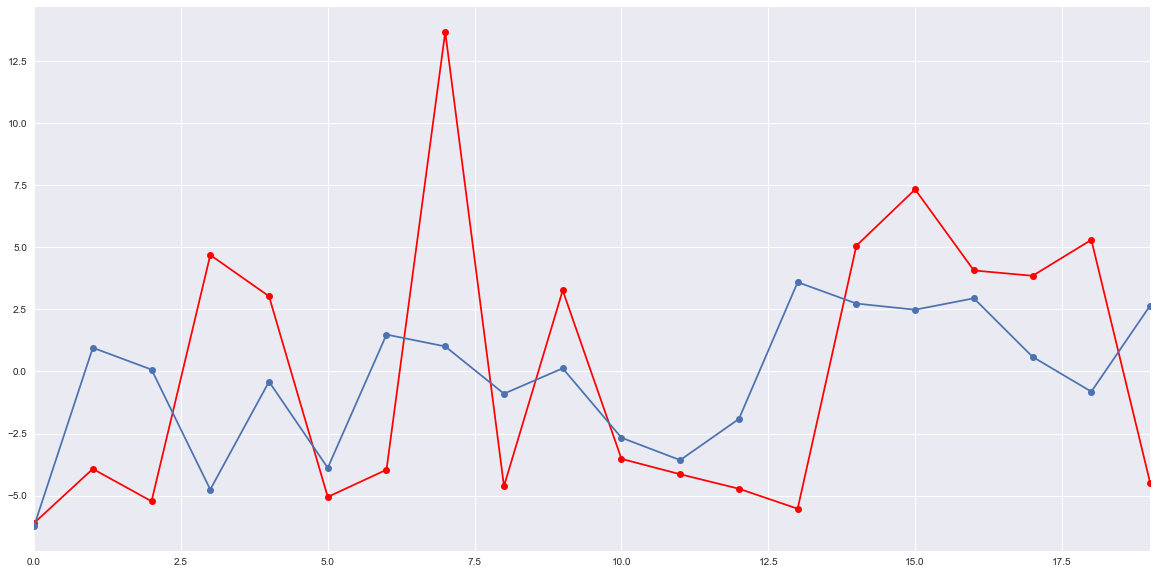

In [25]:
plt.figure(figsize=(20,10))
sns.tsplot(y_test[0:20], color='r', marker='o')
sns.tsplot(y_predicted[0:20], marker='o')

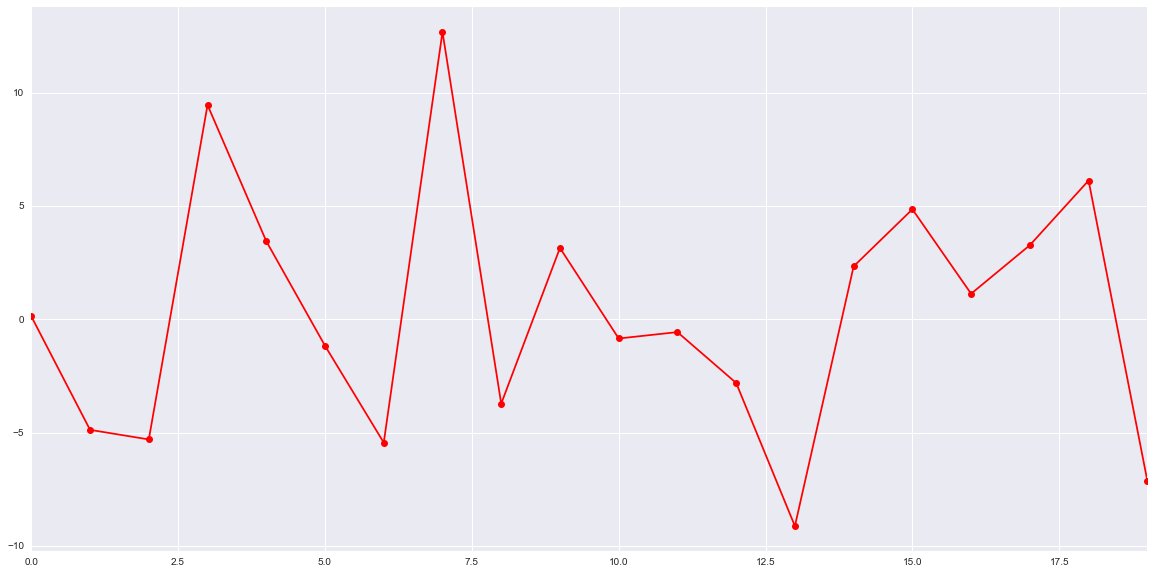

In [26]:
plt.figure(figsize=(20,10))
#sns.tsplot(y_test[0:50])
error = y_test-y_predicted
sns.tsplot(error[0:20], color='r', marker='o')

In [27]:
error_value = mean_squared_error(y_test, y_predicted)

In [28]:
error_value

40.992028371780393

In [29]:
y_test_pos = y_test > 0

In [30]:
y_predicted_pos = y_predicted > 0

In [31]:
diff = y_test_pos != y_predicted_pos

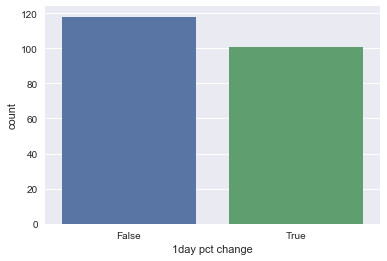

In [32]:
sns.countplot(diff)